# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]()<br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


In [62]:
# Decide if you want to run a region or the country
area = "COUNTRY"
# area = "Copperbelt" # Regions = Central, Copperbelt, Eastern

### Import necessary modules

In [63]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.geometry import shape, mapping
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
#from osgeo import ogr, gdal, osr
import fiona
from rasterstats import zonal_stats
import rasterio
import rasterio.fill
#from geojson import Feature, Point, FeatureCollection
import h3 as h3

# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

In [64]:
# import ipywidgets as widgets
import tkinter as tk
from tkinter import filedialog, messagebox
import datetime
import warnings
import scipy.spatial
warnings.filterwarnings('ignore')

#import seaborn as sns

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [65]:
from utils import processing_raster, finalizing_rasters, spatialjoinvectors

### Define directories and dataset names

In [66]:
os.path.abspath(os.curdir)

'c:\\Users\\rheredia\\OneDrive - Imperial College London\\UKPACT\\EDeMOS_Kenya'

In [67]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs/"

In [68]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

# Part 1. Create base grid with H3

COUNTRY
EPSG:4326


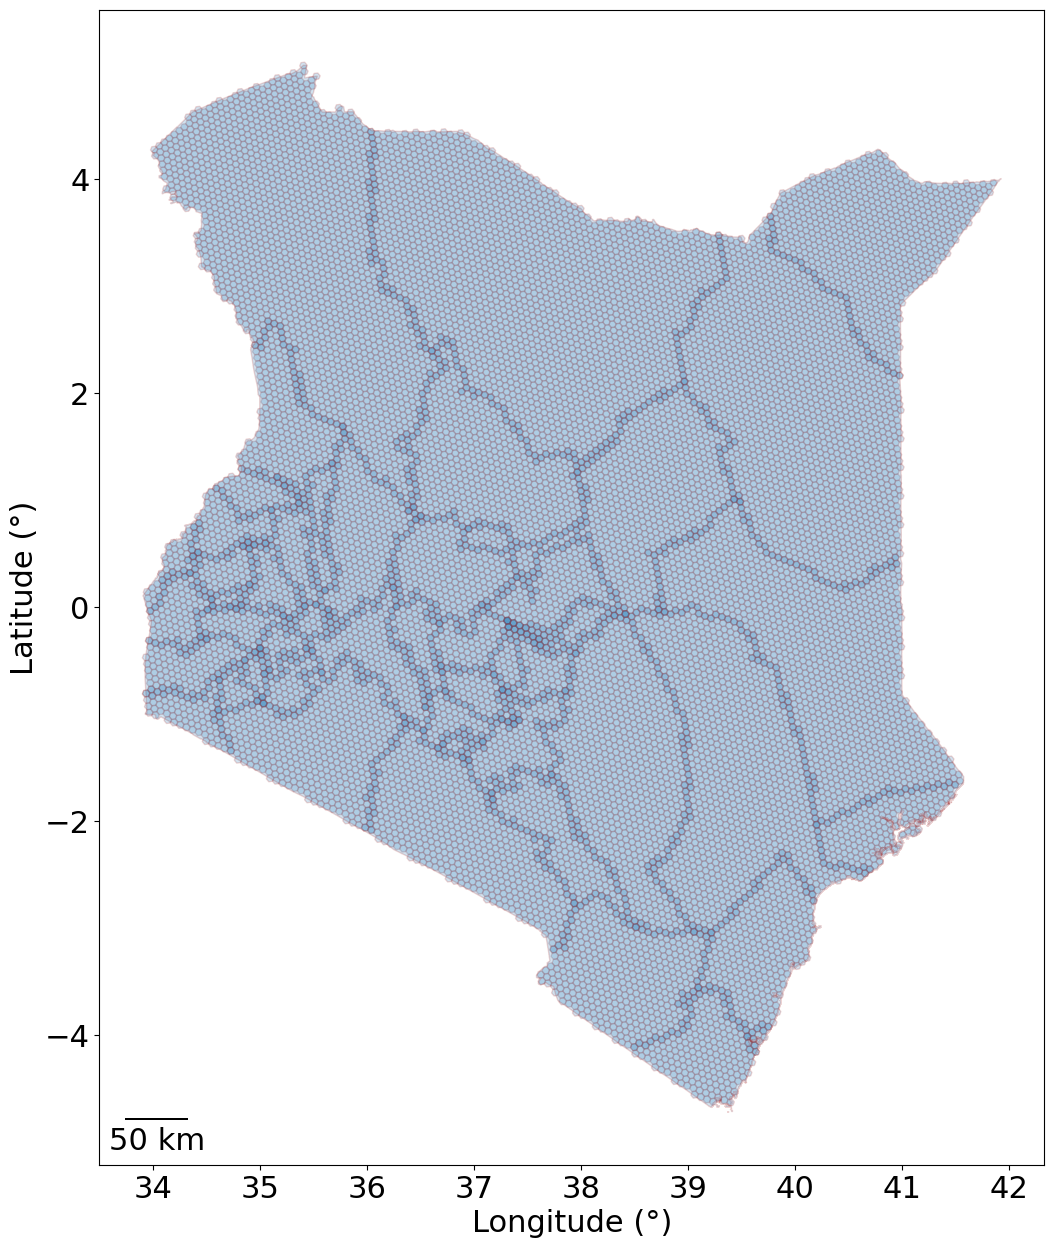

<Figure size 640x480 with 0 Axes>

In [69]:
%run BaseGridHex.ipynb

# Part 2. Extract GIS-based attributes

## Extract raster values to hexagons

##### Once done with rasters run this cell

In [22]:
#grid = finalizing_rasters(out_path, grid, crs_proj)

Final dataframe

In [26]:
# grid.drop(['index_right'], axis=1, inplace=True)
# grid.head(4)

## Extract information from vector layers

In [70]:
## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "gadm41_KEN.gpkg"      
region_col_name = "NAME_1"   ## Provide the name of the column you want to use to clip the hexagons e.g., "NAME" or "ADM1_NAME"
layer_region_name = "ADM_ADM_1"
layer_admin_name = "ADM_ADM_0"
if area == "COUNTRY":
    admin_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_admin_name)
    region_gdf = gpd.read_file(admin_path + "/" + admin_name, layer=layer_region_name)

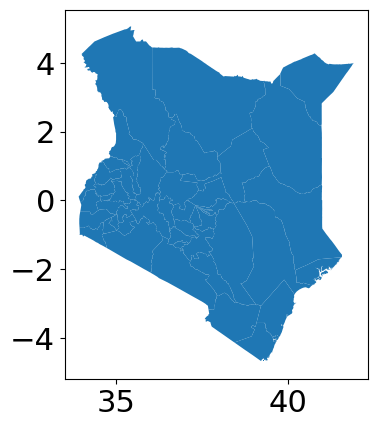

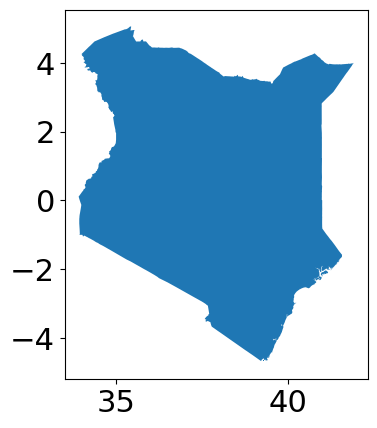

In [71]:
region_gdf.plot(), admin_gdf.plot()
plt.show()

In [72]:
# transmission lines  

#https://energydata.info/dataset/kenya-kenya-electricity-network

# 220KV

lines_gdf = gpd.read_file(ROOT_DIR + "/Grid/Transmission lines 220kV/220kV.shp")

if lines_gdf.crs != crs_WGS84:
    lines_gdf = lines_gdf.to_crs(crs_WGS84)

lines_gdf = gpd.clip(lines_gdf, admin_gdf)

In [73]:
#132kV

lines_132 = gpd.read_file(ROOT_DIR + "/Grid/Transmission lines 132kV/132kV.shp")

if lines_132.crs != crs_WGS84:
    lines_132 = lines_132.to_crs(crs_WGS84)

lines_132 = gpd.clip(lines_132, admin_gdf)

# Part 3. Constructing Multi-vector Demand

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial **

where, 

**Residential** = No of HH with access X average en. cons. kWh/HH/year

**Commercial**  = Number of employee X average en. con. kWh/employee

**Industrial**  = Commodity Production (tonnes) from mines X average energy consumption per tonne

In [74]:
currentdir = os.path.abspath(os.getcwd())
os.path.basename(currentdir)

'EDeMOS_Kenya'

2025-02-07 11:06:19.311596
2025-02-07 11:07:35.909680
2025-02-07 11:09:14.538646
2025-02-07 11:10:14.460820
2025-02-07 11:11:21.617176
2025-02-07 11:12:19.992452
2025-02-07 11:13:25.933458
2025-02-07 11:13:30.926174
-1.434999942779541
1.267071315220424
Residential electricity consumption UN stats 3041.3 GWh
services electricity consumption UN STATS: 1,372 GWh


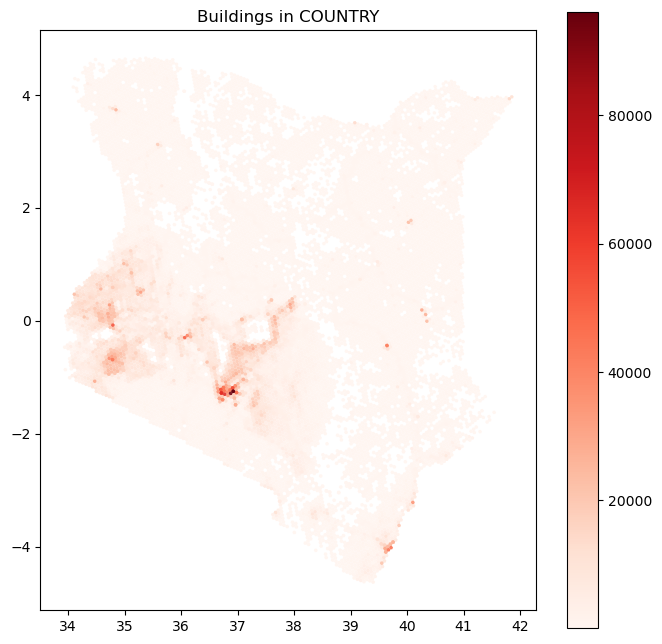

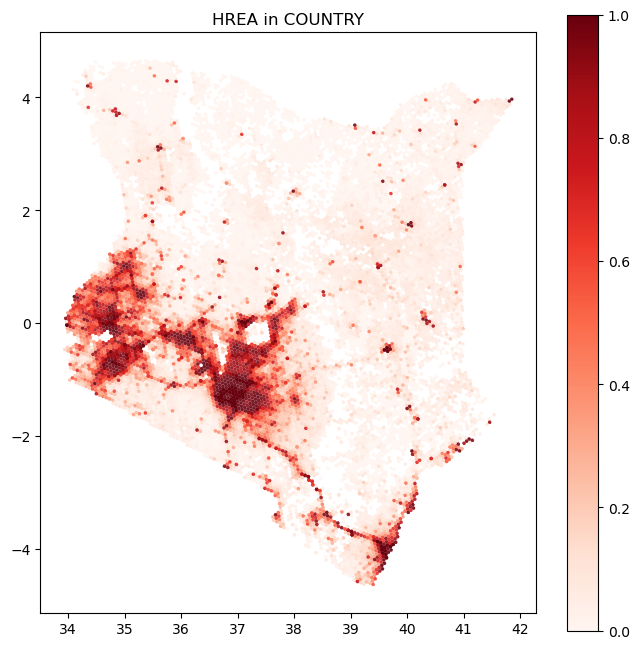

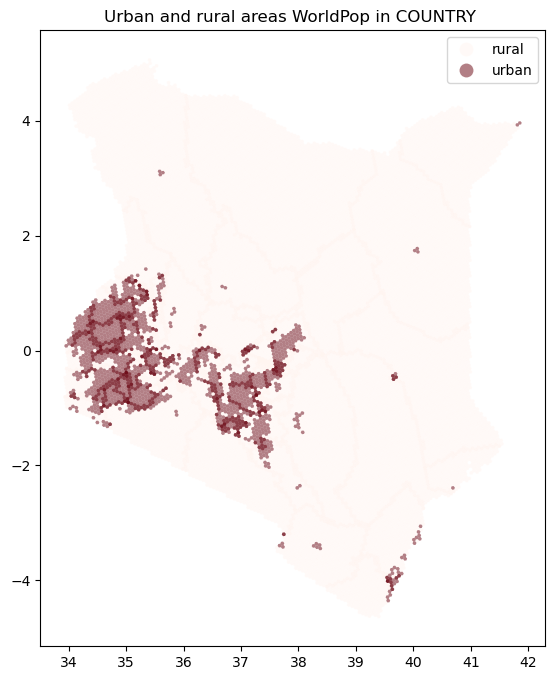

Status_electrified
nonelec    13764
elec        3533
Name: count, dtype: int64
Total population: 46,370,425
Total population: 46,370,425
Total population with access: 22,190,309
Pop access rate : 48%
Pop access rate urban: 63%
Pop access rate rural: 41%


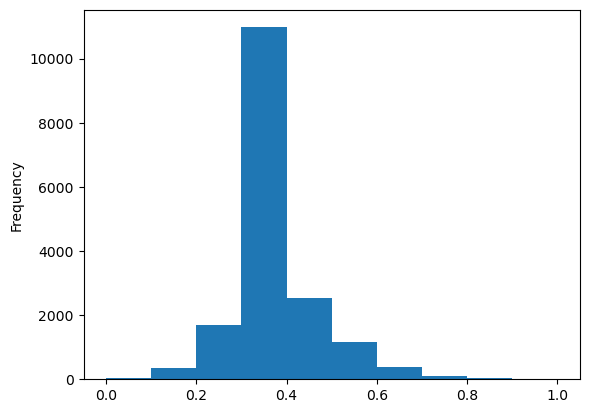

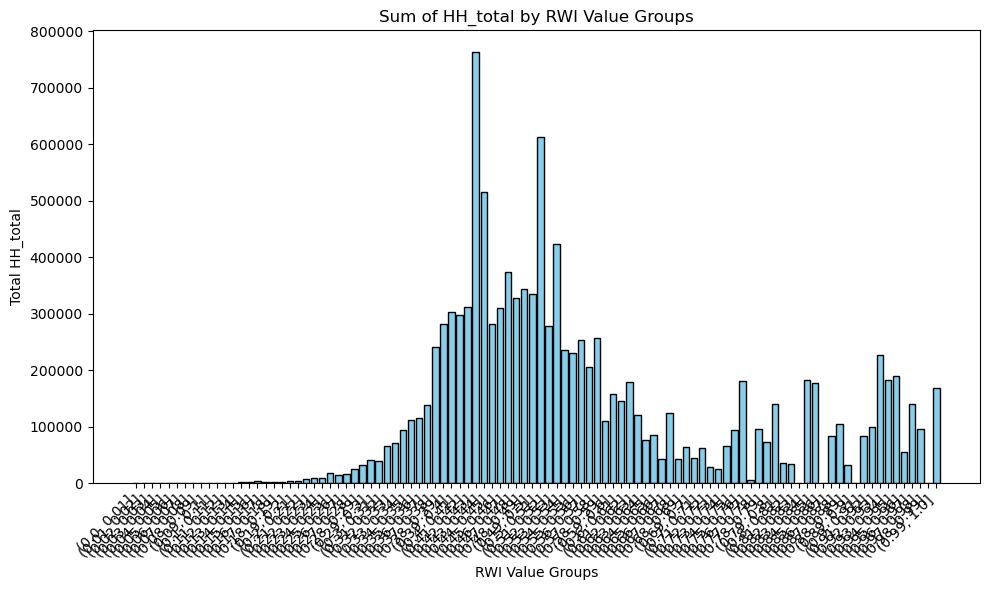

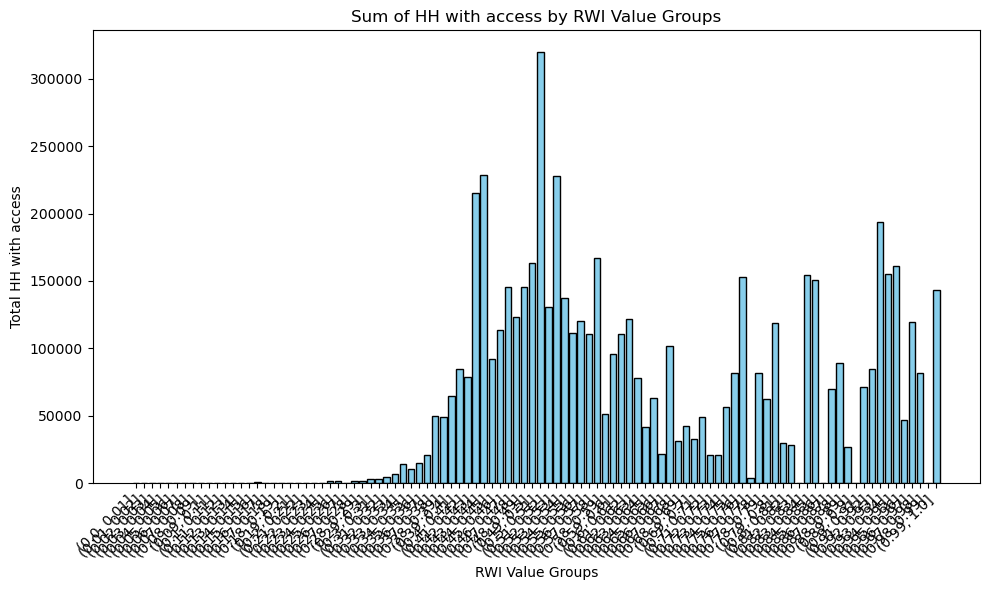

[14.14659708]


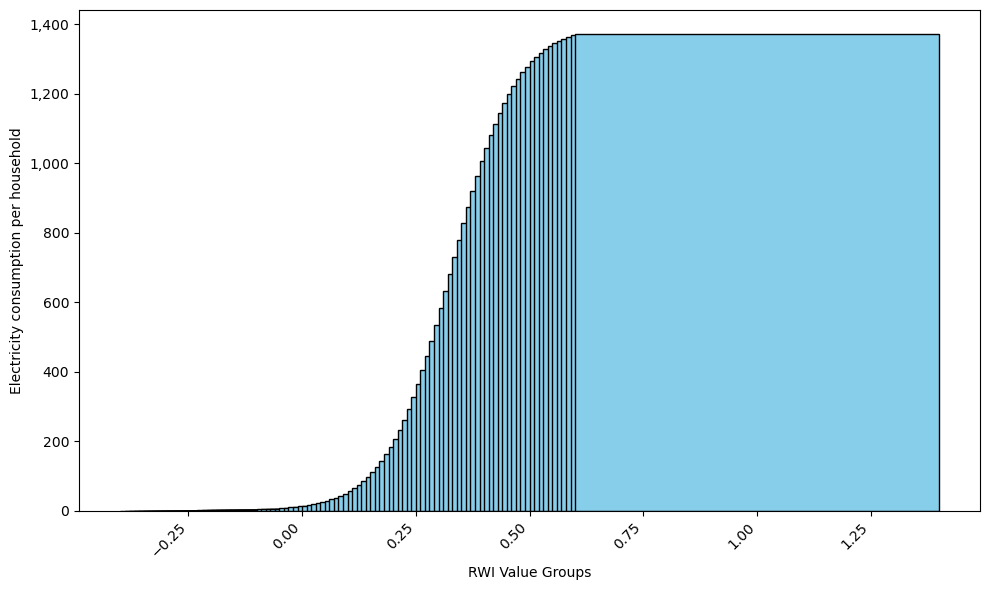

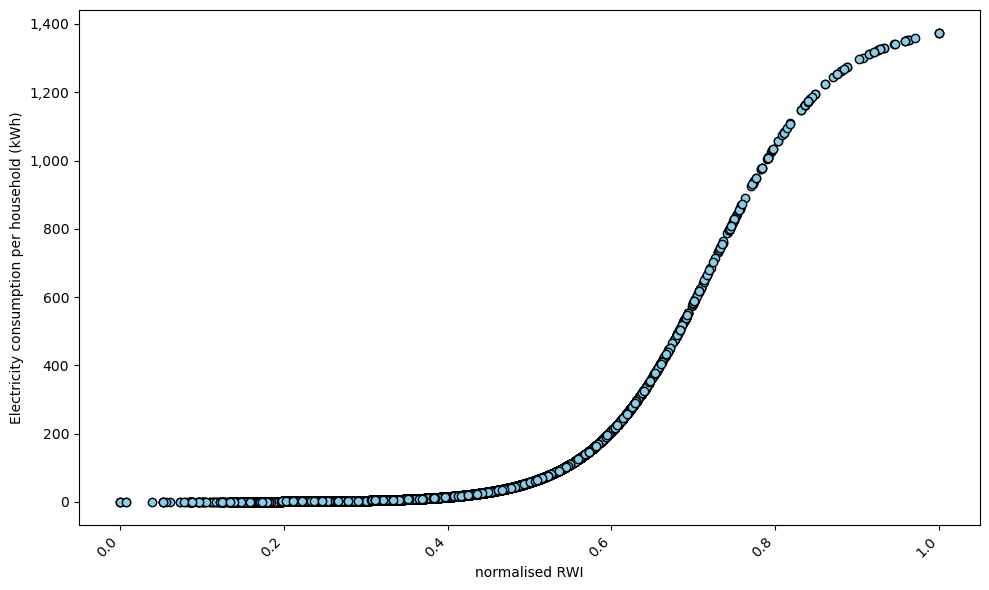

urban total = 3,595 GWh/year
urban average per houshold = 1,217 kWh/year
urban min = 0 kWh/year max = 1,297 kWh/year
Created rwi_vs_energy_use_urban.png


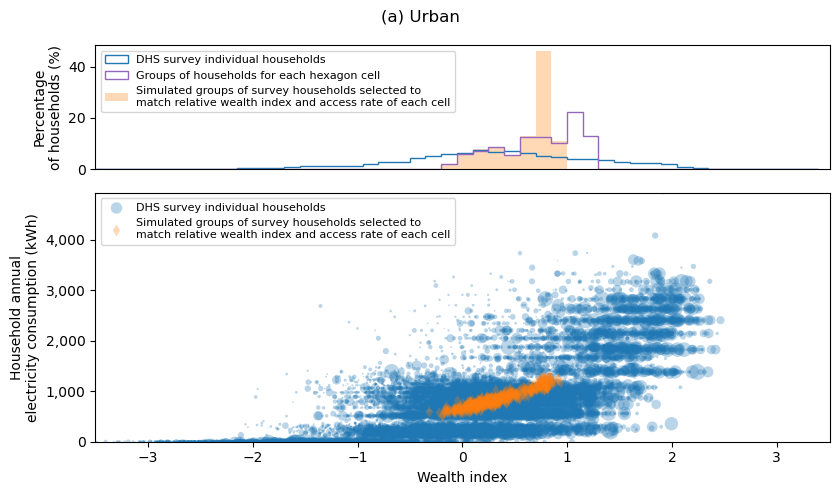

rural total = 1,891 GWh/year
rural average per houshold = 619 kWh/year
rural min = 0 kWh/year max = 738 kWh/year
Created rwi_vs_energy_use_rural.png


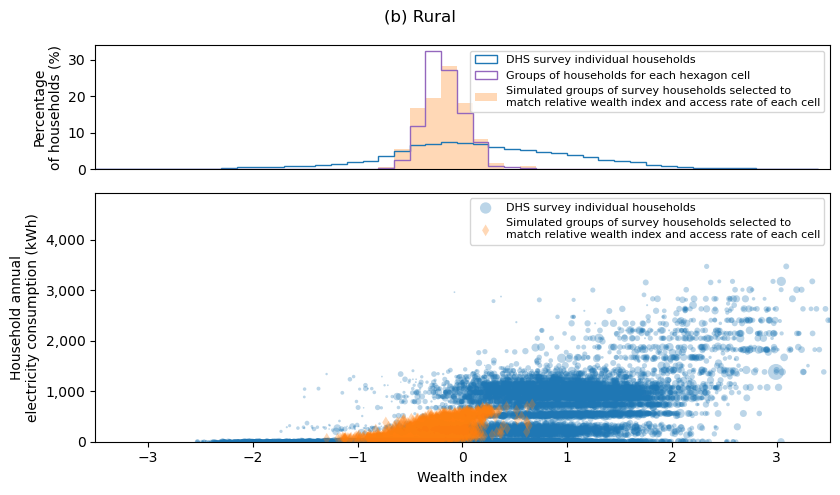

             national  urban  rural
tiers_meth1                        
0                0.50   0.37   0.58
1                0.17   0.01   0.27
2                0.12   0.10   0.14
3                0.11   0.27   0.01
4                0.10   0.25   0.00
5                0.00   0.00   0.00
             national  urban  rural
tiers_meth2                        
0                0.49   0.37   0.57
1                0.00   0.00   0.00
2                0.11   0.00   0.18
3                0.38   0.57   0.25
4                0.02   0.05   0.00
5                0.00   0.00   0.00
Number of lines with similar values: 13906
Mean difference: 0.38191593918020467
Median difference: 0.0
Mode difference: 0   0.00
Name: Difference, dtype: float64
Index(['h3_index', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'index', 'index_righ',
       'NAME_1', 'id', 'buildingssum', 'locationWP', 'HREA', 'rwi',
       'tiers_falchetta_maj', 'tiers_falchetta_mean', 'GDP_PPP', 'geometry',
       'locWorldPop', 'location', 'Stat

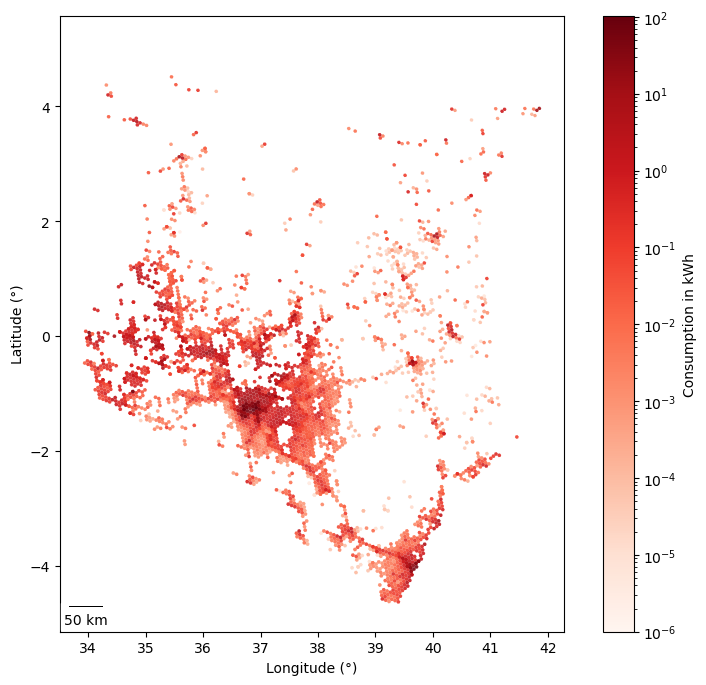

<Figure size 640x480 with 0 Axes>

17,455,049 services buildings
total services buildings with access: 11,633,206
118 kWh per building
total GDP (k$): 11,133,313
123 kWh per unit of GDP (k$)
Total number of women: 5,950,081
Total number of men: 5,696,143
nb of working women 1,678,286
nb of total employee 3,356,571
nb of total employee with access 2,670,028
514 kWh per employee


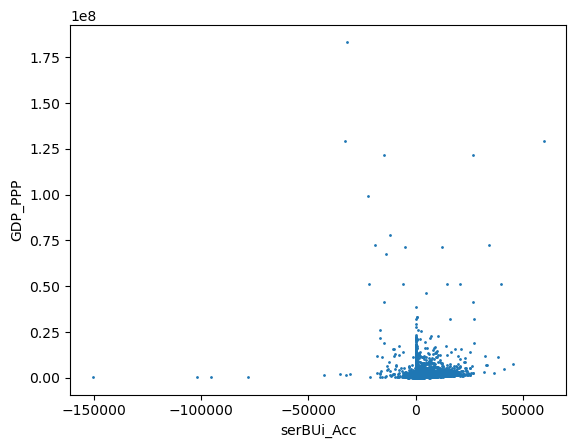

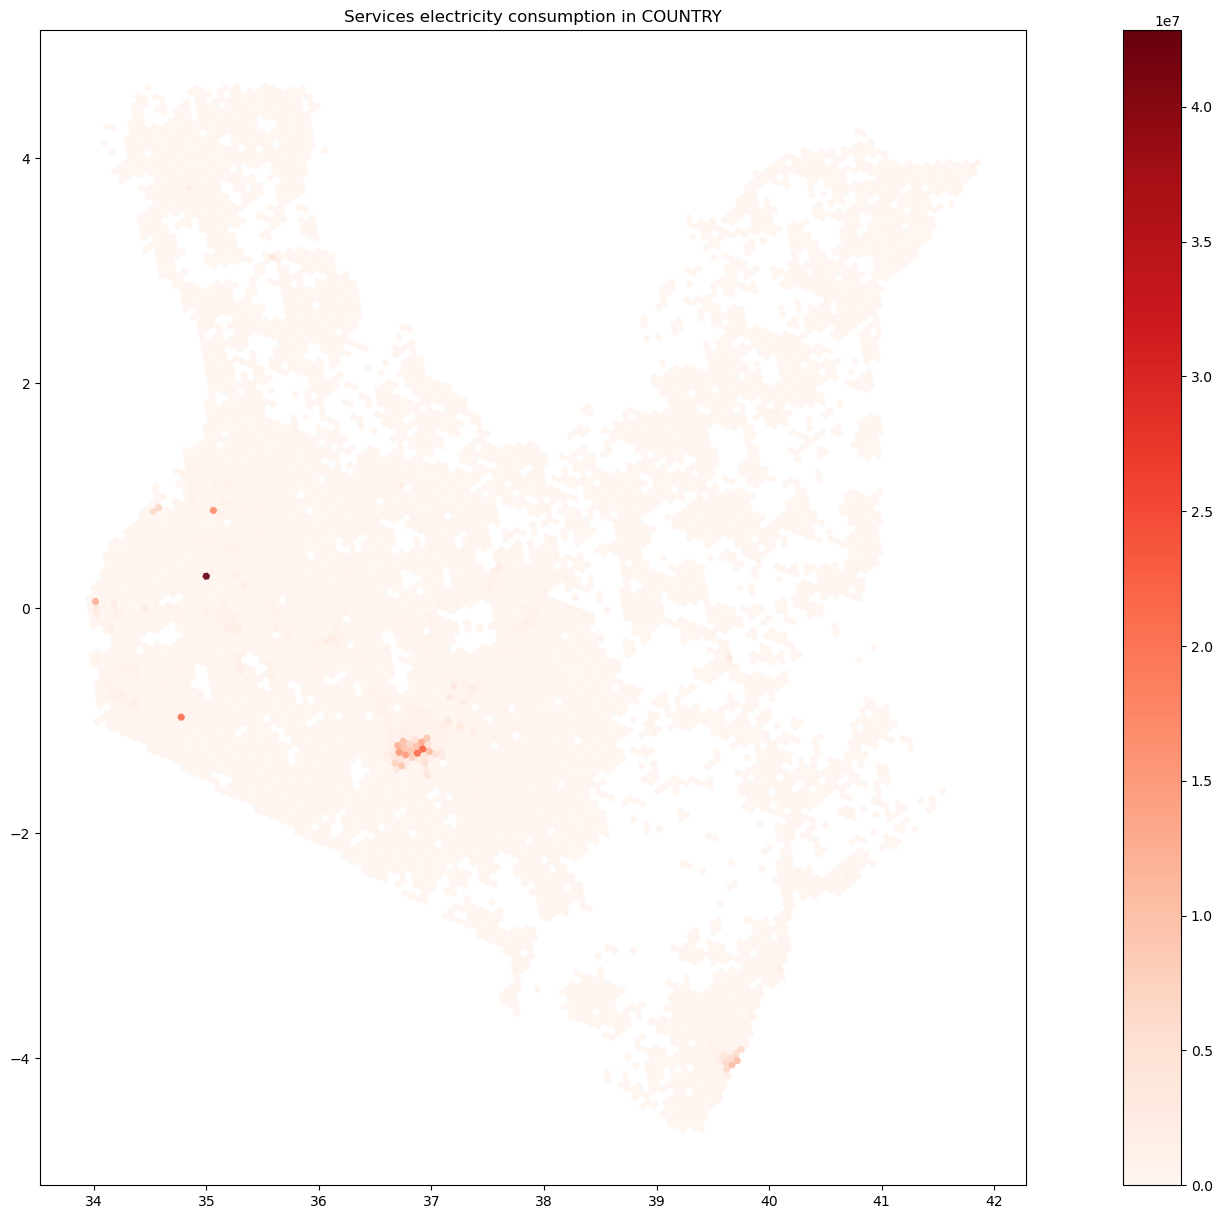

<Figure size 640x480 with 0 Axes>

Services electricity consumption assessed after scaling:
Baringo 20.1 GWh
Bomet 14.7 GWh
Bungoma 43.2 GWh
Busia 22.2 GWh
Elgeyo-Marakwet 8.8 GWh
Embu 20.6 GWh
Garissa 5.7 GWh
Homa Bay 39.1 GWh
Isiolo 5.3 GWh
Kajiado 48.4 GWh
Kakamega 51.5 GWh
Kericho 18.1 GWh
Kiambu 99.7 GWh
Kilifi 40.0 GWh
Kirinyaga 22.8 GWh
Kisii 30.3 GWh
Kisumu 36.9 GWh
Kitui 26.3 GWh
Kwale 16.2 GWh
Laikipia 12.6 GWh
Lamu 3.3 GWh
Machakos 48.0 GWh
Makueni 23.1 GWh
Mandera 2.5 GWh
Marsabit 0.0 GWh
Meru 39.8 GWh
Migori 23.1 GWh
Mombasa 57.3 GWh
Murang'a 25.0 GWh
Nairobi 240.3 GWh
Nakuru 67.0 GWh
Nandi 19.5 GWh
Narok 27.3 GWh
Nyamira 0.0 GWh
Nyandarua 13.8 GWh
Nyeri 30.5 GWh
Samburu 6.8 GWh
Siaya 24.3 GWh
Taita Taveta 9.8 GWh
Tana River 2.7 GWh
Tharaka-Nithi 10.6 GWh
Trans Nzoia 23.7 GWh
Turkana 30.1 GWh
Uasin Gishu 46.7 GWh
Vihiga 0.0 GWh
Wajir 6.2 GWh
West Pokot 8.0 GWh
NAME_1
Baringo            20.13
Bomet              14.69
Bungoma            43.17
Busia              22.25
Elgeyo-Marakwet     8.80
Embu             

In [76]:
%run Residential/building_demand.ipynb

In [77]:
total_residentialenergy_assessed = grid['ResEnergy_kWh_meth2'].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh

residential electricity consumption: 4,217 GWh


In [78]:
#%run Industry/IndustryDemand.ipynb
#print("Industry electricity consumption in",f"{area}",f"{total_industryenergy/3600:,.1f}", "TWh")

In [79]:
# Concatenate results
out_path = ROOT_DIR + "/Outputs/"
gridBui = gpd.read_file(out_path + "ser_energy_map.geojson") # contains services and residential data
#gridInd = gpd.read_file(out_path + "ind_energy_map.geojson")

grid = gridBui.copy()
#grid = grid.merge(gridInd, on='id', suffixes=('', '_y'))
grid.drop(grid.filter(regex='_y$').columns, axis=1, inplace=True)
grid.head(4)

h3_index     n0     n1     n2     n3     n4     n5  index  \
0  867a634cfffffff  10544   7997   5898   6727  15194   1698      0   
1  867a72167ffffff  10081   5251   9684  12059      0      0      1   
2  867a5a967ffffff  10819  13317  13708  11583   4710   2395      2   
3  867b4a467ffffff  10461  11643  15072   5170  14495  14660      3   

   index_righ    NAME_1  ...  nb_women  nb_men  nb_women_working  \
0          17     Kitui  ...    473.64  427.88             99.42   
1           6   Garissa  ...     13.88   16.60              0.66   
2          24  Marsabit  ...     36.99   40.82              1.06   
3          18     Kwale  ...   1269.56 1193.75            201.35   

   nb_men_working  total_employee  total_employee_withaccess  SEn_kWh_Emp  \
0           99.42          198.83                     198.83    102148.61   
1            0.66            1.33                       0.00       683.15   
2            1.06            2.12                       0.00      1090.65   
3          201.35          402.71                     402.71    206885.67   

   SEn_kWh_weighted SEn_kWh_final  \
0         102148.61      82829.43   
1               NaN           NaN   
2               NaN           NaN   
3         206885.67     167757.77   

                                            geometry  
0  POLYGON ((37.88339 -1.14532, 37.84872 -1.15023...  
1  POLYGON ((40.99339 -0.00993, 40.95962 -0.01464...  
2  POLYGON ((37.78967 3.51913, 37.75565 3.51485, ...  
3  POLYGON ((39.52861 -4.35945, 39.49385 -4.36482...  

[4 rows x 75 columns]

In [80]:
# Units
#grid["IndEnergy_GWh"]=grid["IndEne_TJ"]/3600 *10**3
#grid['IndEnergy_kWh'] = grid['IndEnergy_GWh'] * 10**6
#total_ind = grid["IndEnergy_GWh"].sum()
#print(f"Industry: {total_ind:,.0f}", "GWh")
grid['REnS_kWh'] = grid['ResEnergy_kWh_meth2_scaled']
grid['REnS_GWh'] = grid['REnS_kWh'] / 10**6
total_res = grid["REnS_GWh"].sum()
print(f"Residential: {total_res:,.0f}", "GWh")
grid['SEn_GWh'] = grid['SEn_kWh_final'] / 10**6
grid['SEn_kWh'] = grid['SEn_GWh'] * 10**6
total_ser = grid["SEn_GWh"].sum()
print(f"Services: {total_ser:,.0f}", "GWh")

Residential: 0 GWh
Services: 1,372 GWh


In [81]:
grid["TotalDem_GWh"] = grid.apply(lambda row: (np.nansum([row['REnS_GWh'], 
                                          row['SEn_GWh'],  
                                                ])), axis=1) #sum in GWh
grid["TotalDem_kWh"]= grid['TotalDem_GWh'] * 10**6
total = grid["TotalDem_GWh"].sum()
print("total electricity consumption:", f"{total:,.0f}","GWh") # GWh

total electricity consumption: 1,372 GWh


In [82]:
grid.head(3)

h3_index     n0     n1     n2     n3     n4    n5  index  \
0  867a634cfffffff  10544   7997   5898   6727  15194  1698      0   
1  867a72167ffffff  10081   5251   9684  12059      0     0      1   
2  867a5a967ffffff  10819  13317  13708  11583   4710  2395      2   

   index_righ    NAME_1  ...  SEn_kWh_Emp  SEn_kWh_weighted  SEn_kWh_final  \
0          17     Kitui  ...    102148.61         102148.61       82829.43   
1           6   Garissa  ...       683.15               NaN            NaN   
2          24  Marsabit  ...      1090.65               NaN            NaN   

                                            geometry  REnS_kWh  REnS_GWh  \
0  POLYGON ((37.88339 -1.14532, 37.84872 -1.15023...      0.01      0.00   
1  POLYGON ((40.99339 -0.00993, 40.95962 -0.01464...      0.00      0.00   
2  POLYGON ((37.78967 3.51913, 37.75565 3.51485, ...      0.00      0.00   

   SEn_GWh  SEn_kWh TotalDem_GWh TotalDem_kWh  
0     0.08 82829.43         0.08     82829.44  
1      NaN      NaN         0.00         0.00  
2      NaN      NaN         0.00         0.00  

[3 rows x 81 columns]

### Export result

In [83]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [84]:
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    grid.to_file(out_path + 'total_demand_grid.gpkg', driver="GPKG", index=False, engine='fiona')
#grid.to_file(out_path + 'total_demand_grid.geojson', driver="GeoJSON")
grid.to_file(out_path + f'total_demand.geojson', driver='GeoJSON', index=False)  

## Print maps for quick assessment

In [85]:
plt.rcParams.update({'font.size': 22})

### Total demand map

In [86]:
# # Plot the demand map with use of the full scale
# # Create the axis first
# fig, ax = plt.subplots(figsize=(10, 15))

# # Plot data
# grid.sort_values('TotalDem_GWh', ascending=True).plot(
#     ax=ax, column='TotalDem_GWh', cmap="Reds", legend=True, alpha=0.5)

# ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# # Save plot as figure 
# plt.savefig(out_path +'total_elec_demand_map.png', bbox_inches='tight')

In [87]:
# # Plot the demand map with a threshold value
# # Create the axis first
# # fig, ax = plt.subplots(figsize=(25, 15))
# fig, ax = plt.subplots(figsize=(15, 10))

# # Set the threshold
# # threshold = np.percentile(npgrid['TotalDem'], 90)
# threshold = 0.1 * grid['TotalDemGWh'].max()

# # Plot data
# grid.sort_values('TotalDem_GWh', ascending=True).plot(
#     ax=ax, column='TotalDem_GWh', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# # Save plot as figure 
# plt.savefig(out_path +'total_demand_elec_map_threshold.png', bbox_inches='tight')

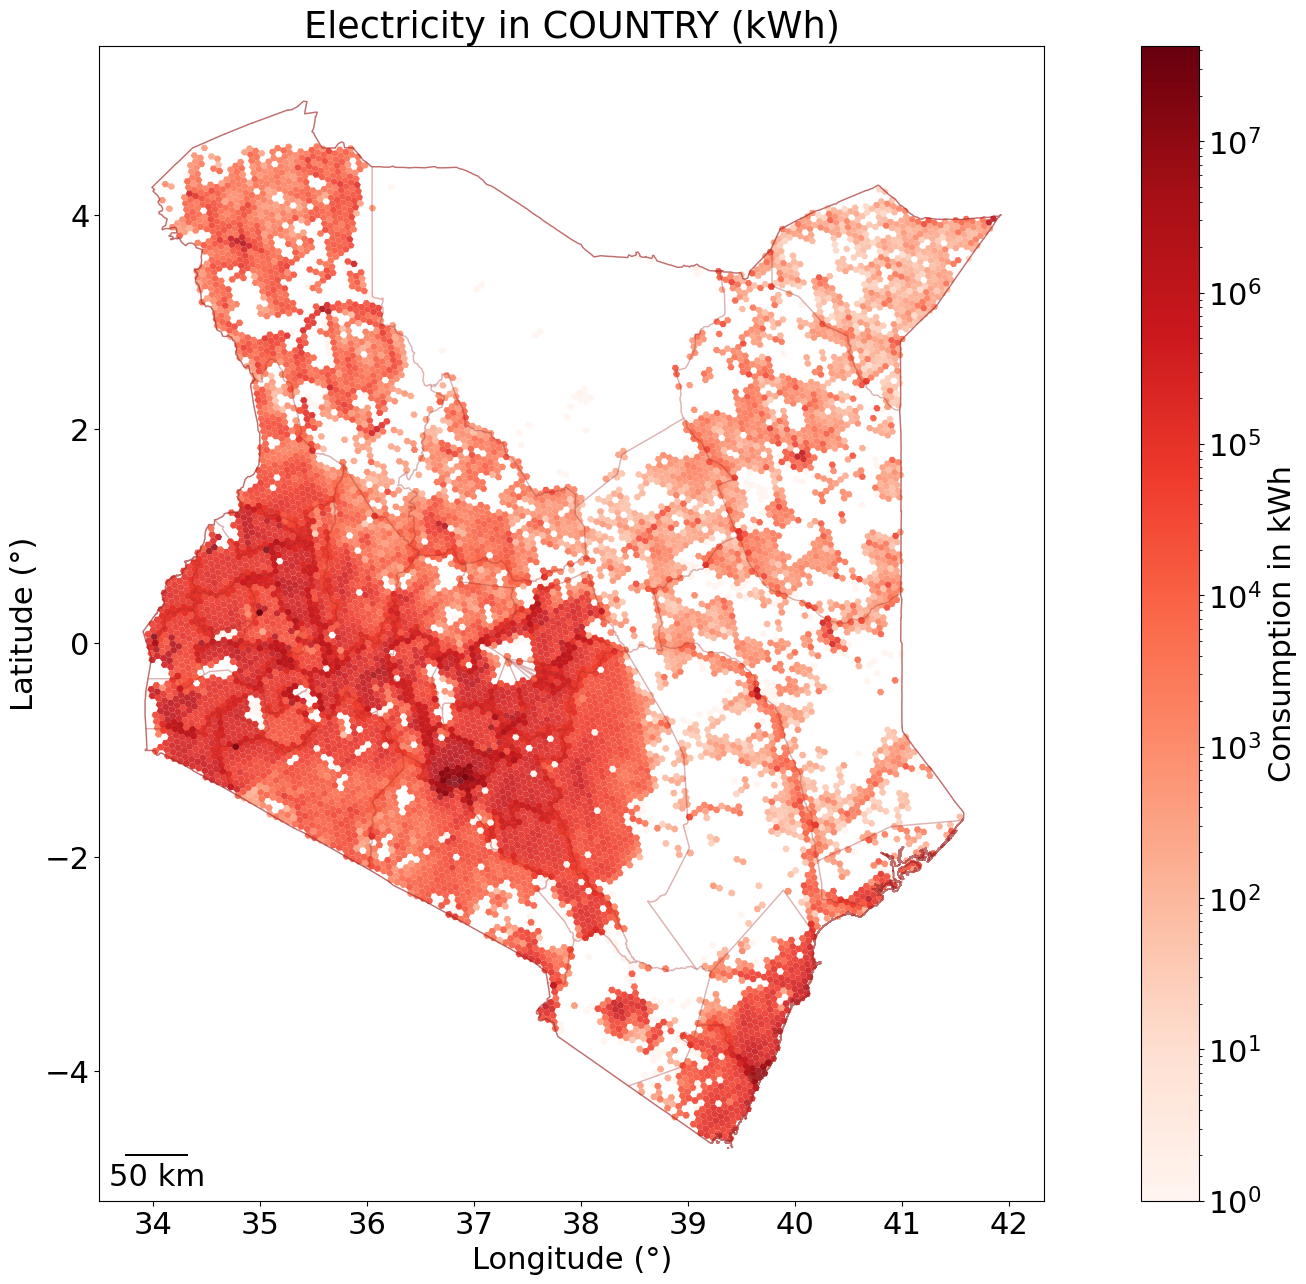

In [88]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Plot data
grid.sort_values('TotalDem_kWh', ascending=True).plot(
    ax=ax, column='TotalDem_kWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['TotalDem_kWh'].max()),
    legend_kwds={"label": "Consumption in kWh"})

admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format(area) )

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)

ax.add_artist(scalebar)

# Save plot as figure 
plt.savefig(out_path +'total_demand_elec_log.png', bbox_inches='tight')

In [89]:
print(lines_gdf.crs)
print(grid.crs)
print(admin_gdf.crs)
print(region_gdf.crs)

EPSG:4326
+init=epsg:4326 +type=crs
EPSG:4326
EPSG:4326


### Residential map

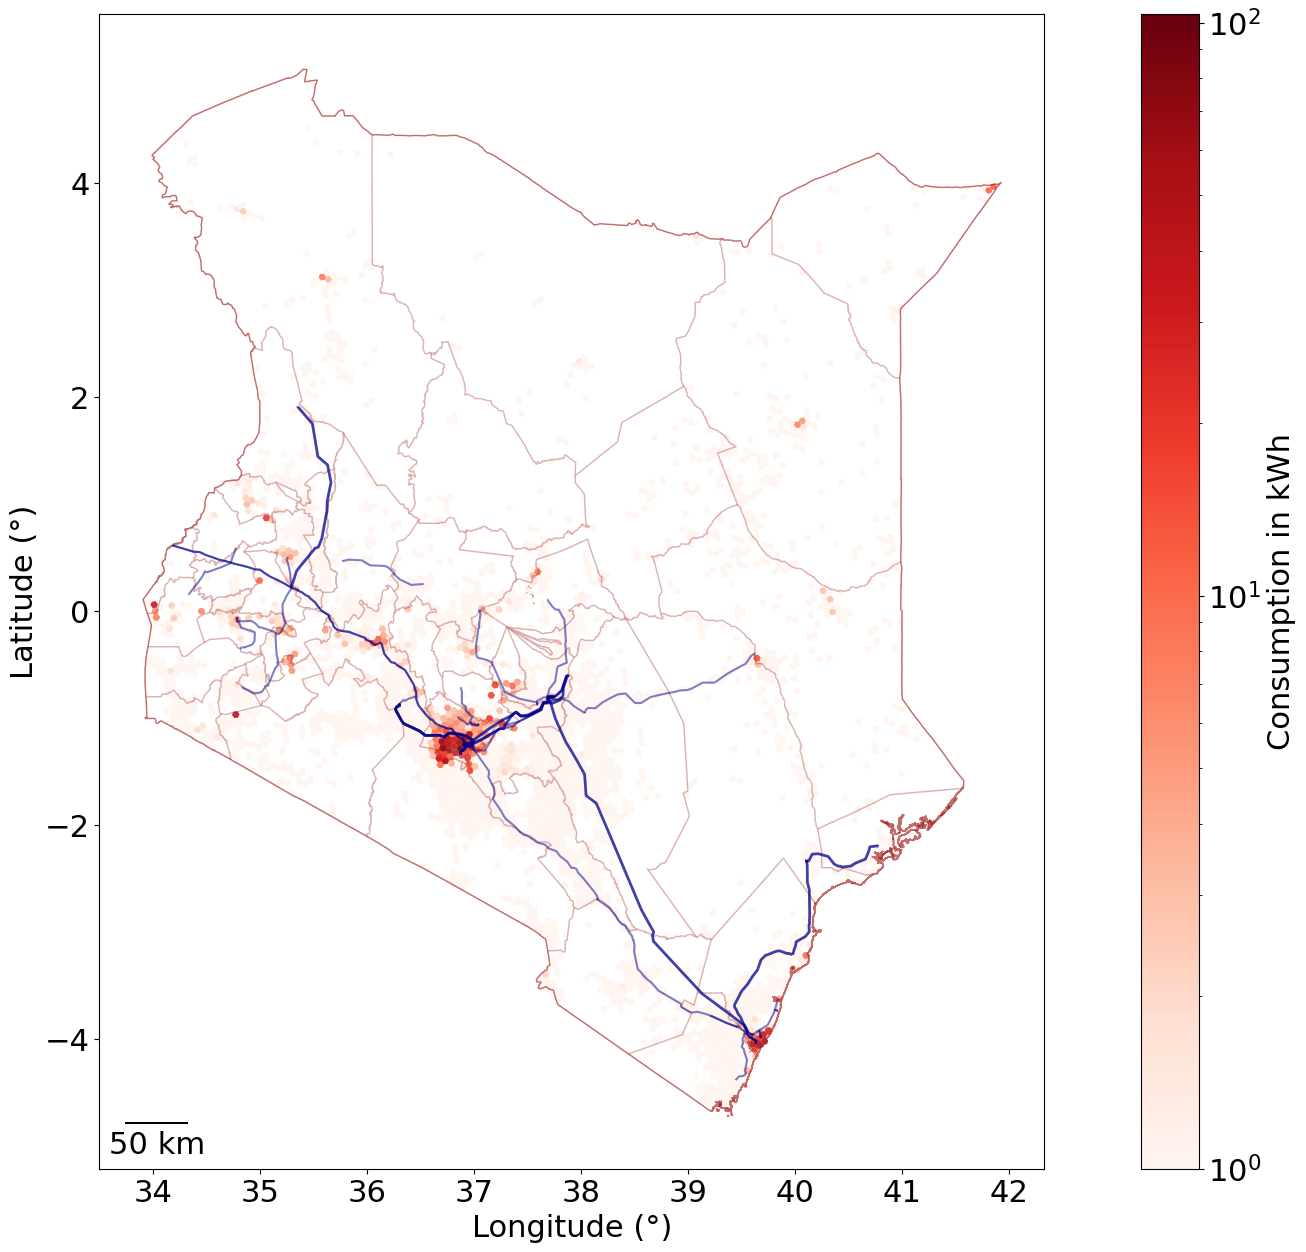

In [90]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Plot data
grid.sort_values('REnS_kWh', ascending=True).plot(
    ax=ax, column='REnS_kWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['REnS_kWh'].max()),
    legend_kwds={"label": "Consumption in kWh"}) #, "orientation": "horizontal"})

admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.75, linewidth=2)
lines_132.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.5, linewidth=1.5)

ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity consumption in the residential sector in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity consumption in the residential sector (kWh)' )

# print(grid.crs)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)

ax.add_artist(scalebar)

# Save plot as figure 
plt.savefig(out_path +'map_residential_log.png', bbox_inches='tight')

### Services map

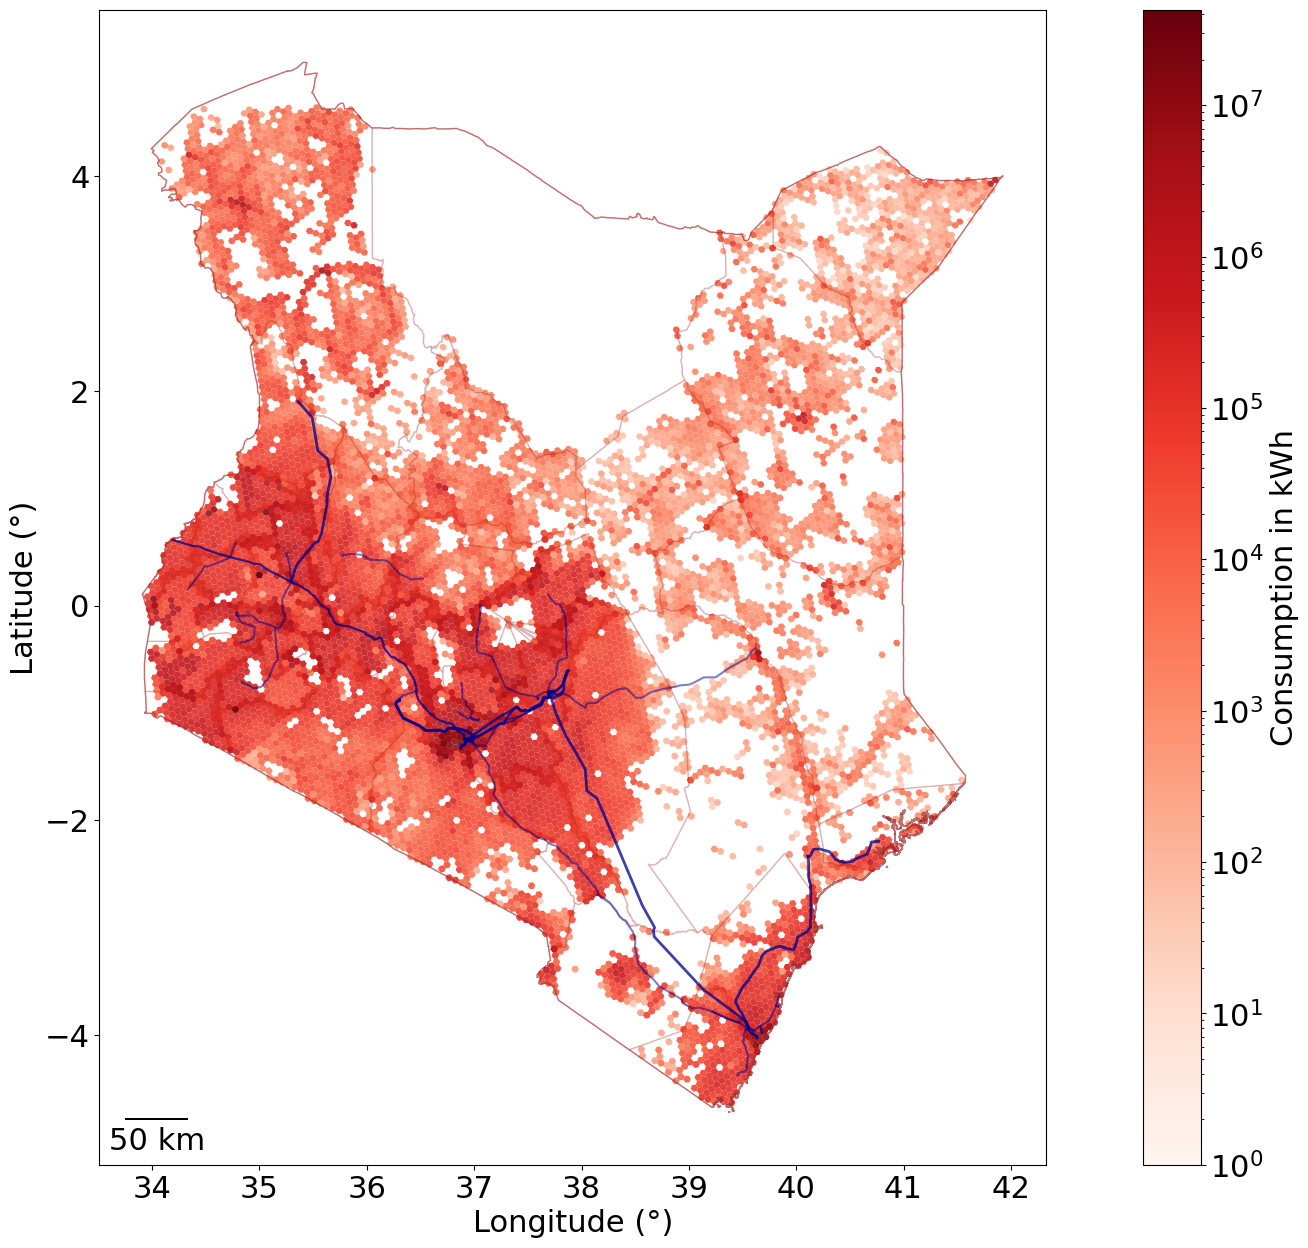

In [91]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')


# Plot data
grid.sort_values('SEn_kWh', ascending=True).plot(
    ax=ax, column='SEn_kWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['SEn_kWh'].max()),
    legend_kwds={"label": "Consumption in kWh"})
admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.75, linewidth=2)
lines_132.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.5, linewidth=1.5)

# # Plot data
# grid.sort_values('TotalDem', ascending=True).plot(
#     ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('TotalDem', ascending=True).plot(
#     ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.9)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)
ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in the services sector in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity in the services sector (GWh)')

ax.add_artist(scalebar)
# Save plot as figure 
plt.savefig(out_path +'map_services_log.png', bbox_inches='tight')

### Buildings map

In [92]:
grid['Bui_GWh'] = grid['SEn_GWh']+grid['REnS_GWh']
grid['Bui_kWh'] = grid['SEn_kWh']+grid['REnS_kWh']

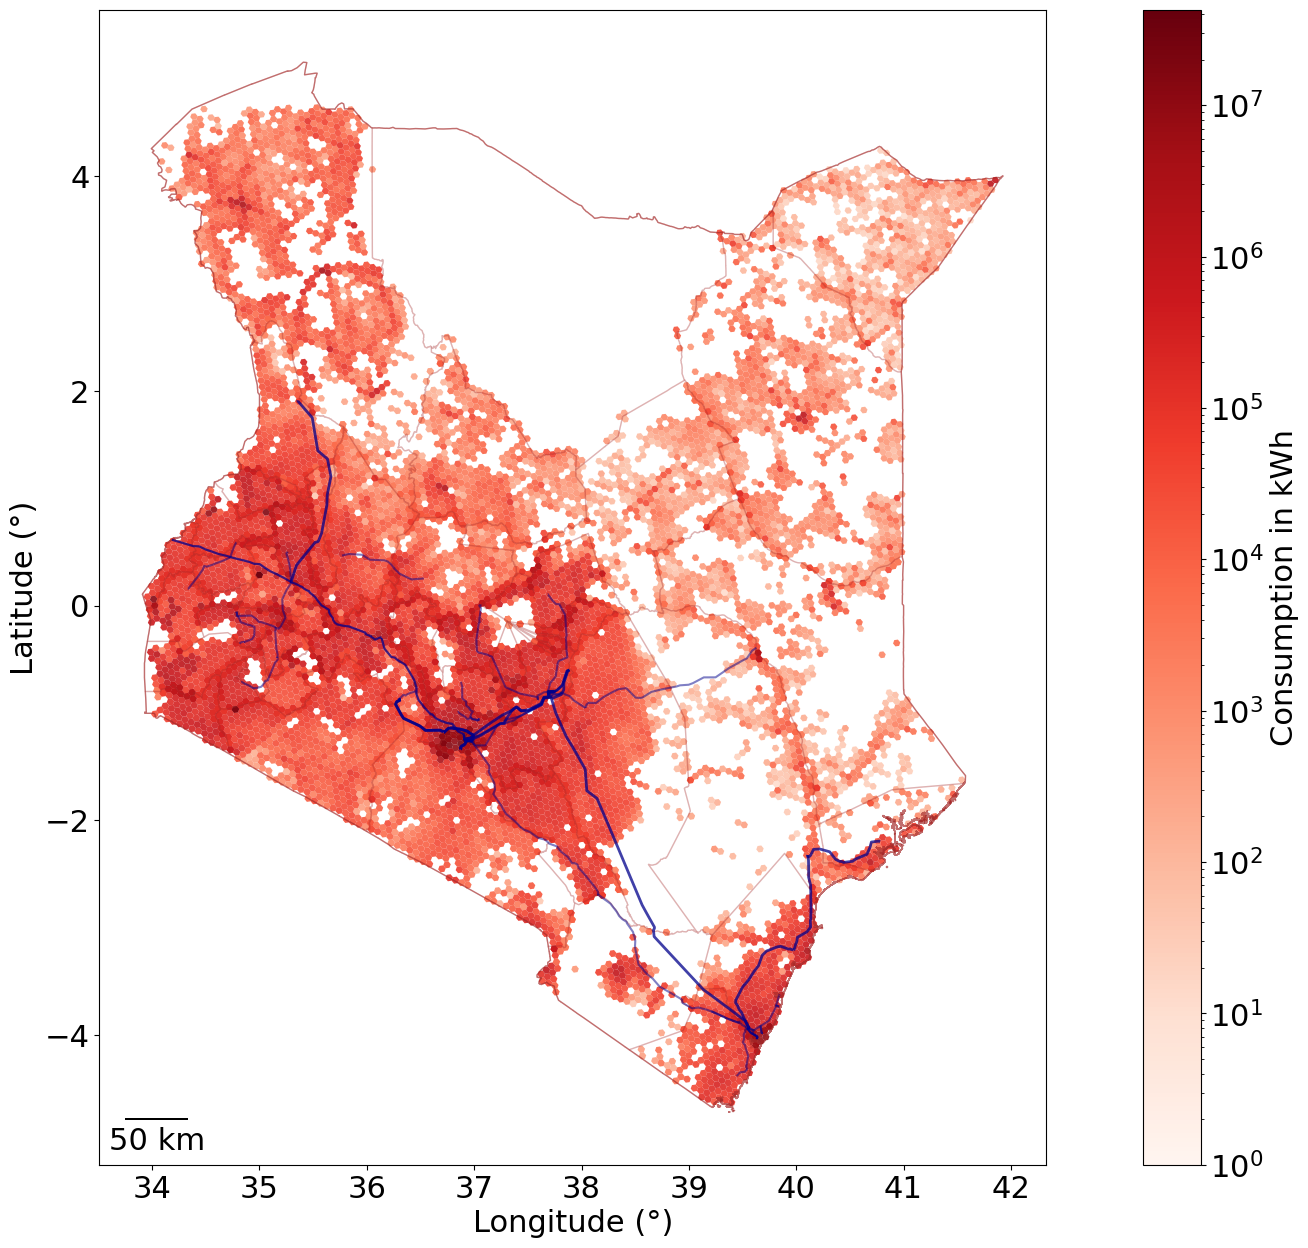

In [93]:
# Plot the demand map with a log scale value
# Create the axis first
# sns.set_theme('poster')
# sns.set_style('white')
fig, ax = plt.subplots(figsize=(25, 15))
# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')


# Plot data
grid.sort_values('Bui_kWh', ascending=True).plot(
    ax=ax, column='Bui_kWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['Bui_kWh'].max()),
    legend_kwds={"label": "Consumption in kWh"})
admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
lines_gdf.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.75, linewidth=2)
lines_132.plot(ax=ax, edgecolor='darkblue', color='darkblue', alpha=0.5, linewidth=1.5)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)
ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity in buildings in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity in buildings (GWh)')

ax.add_artist(scalebar)
# Save plot as figure 
plt.savefig(out_path +'map_buildings_log.png', bbox_inches='tight')

### Industry map

In [94]:
# # Plot the industry demand map per cell
# # Create the axis first
# fig, ax = plt.subplots(figsize=(25, 15))

# # Plot data with a log scale value
# grid.sort_values('IndEnergy_kWh', ascending=True).plot(
#     ax=ax, column='IndEnergy_kWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['IndEnergy_kWh'].max()),
#     legend_kwds={"label": "Consumption in kWh"})

# # # Plot data
# # grid.sort_values('IndEnergy_GWh', ascending=True).plot(
# #     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # # Plot data
# # grid.sort_values('IndEnergy_GWh', ascending=True).plot(
# #     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.9)

# admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
# region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# # lines_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)

# # Compute the distance-per-pixel of the map
# # see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# # assert grid.crs == 'EPSG:4326'
# from shapely.geometry.point import Point
# points = gpd.GeoSeries(
#     [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
# )  # Geographic WGS 84 - degrees
# points = points.to_crs(32619)  # Projected WGS 84 - meters
# distance_meters = points[0].distance(points[1])

# # Add a scale bar
# scalebar = ScaleBar(
#     distance_meters,
#     dimension="si-length",
#     location='lower left',
#     length_fraction=0.1,
#     width_fraction=0.001,
#     units='m',
#     color='black',
#     fixed_value=None
# )

# ax.set_aspect('equal', 'box')
# # txt = ax.set_title('Electricity in the mining sector in {} (GWh)'.format(area) )
# ax.add_artist(scalebar)
# # Save plot as figure 
# plt.savefig(out_path +'map_industry_log.png', bbox_inches='tight')

In [95]:
#(grid['IndEnergy_GWh'] != 0).sum()

In [96]:
#(grid['IndEnergy_GWh'] > 50).sum()

In [97]:
# totalperregion=grid.groupby('NAME_1')['IndEnergy_GWh'].sum()
# totalperregion

In [98]:
#grid['totalindeperregion'] = grid['NAME_1'].map(totalperregion)

In [99]:
# # Plot the demand map with a log scale value
# # Create the axis first
# fig, ax = plt.subplots(figsize=(25, 15))

# # Plot data
# grid.sort_values('totalindeperregion', ascending=True).plot(
#     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['totalindeperregion'].max()))

# # # Plot data
# # grid.sort_values('totalindeperregion', ascending=True).plot(
# #     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # # Plot data
# # grid.sort_values('totalindeperregion', ascending=True).plot(
# #     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.9)
# admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.05)
# ax.set_aspect('equal', 'box')
# ax.set_title('Electricity in the mining sector in Zambia (GWh)')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

# from matplotlib.ticker import FuncFormatter

# # fmt = lambda x, pos: '{:.1%}'.format(x)
# # cbar = plt.colorbar(format=FuncFormatter(fmt))

# # Save plot as figure 
# plt.savefig(out_path +'map_log_ind.png', bbox_inches='tight')